## Assignment II: Data Structures and Methods for HPC

# Exercise 1 - Pytest with Julia Set Code

Julia code with assert statement removed and replaced with a return of output for the function.

In [8]:
"""Julia set generator without optional PIL-based image drawing"""
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -0.42193


# decorator to time
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result

    return measure_time


def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    print("the sum is: ", sum(output))

    return output


def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    calc_pure_python(desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 1.9679391384124756 seconds
the sum is:  33219980


Pytest of the function which replaced the assert statment and accounts for multiple test cases and dimensions.

In [9]:
import ipytest
import pytest
ipytest.autoconfig()

In [10]:
%%ipytest -v

@pytest.mark.parametrize('width, iterations, expected', [(1000, 300, 33219980), (10, 3, 177)])
def test_calc_pure_python(width, iterations, expected):
    output = calc_pure_python(width, iterations)
    assert sum(output) == expected

======================================= test session starts ========================================
platform darwin -- Python 3.12.2, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/marcuscarlbom/Programming/github/hpc/A2
collected 2 items

t_2f34c20259584d9fbc048d5e3622caaa.py ..                                                     [100%]

======================================== 2 passed in 2.08s =========================================


To include unit tests with different numbers or iterations, an expected value is necessary but easily implemented in the above code as another tuple in the list. Add one tuple after the two given cases, right of the (10, 3, 177), and it would be able to test the sum of output given different inputs.

# Exercise 2 - Python DGEMM Benchmark Operation#

### Task 2.1 
Implement the DGEMM with matrices as NumPy array

Original C code:

In [11]:
# // Multiplying first and second matrices and storing it in result
#    for (int i = 0; i < N; ++i) {
#       for (int j = 0; j < N; ++j) {
#          for (int k = 0; k < N; ++k) {
#             C[i][j] = C[i][j] + A[i][k] * B[k][j];
#          }
#       }
#    }

Python translation of the C code:

In [12]:
import numpy as np
import timeit

Uses psudo random number generator to deterministically generate the matrices A, B, and C. 

In [13]:
seed = 1
N = 100
np.random.seed(seed)

A = np.random.randint(-N, N, (N, N))
B = np.random.randint(-N, N, (N, N))
C = np.random.randint(-N, N, (N, N))

# print("A is : \n", A)
# print("B is : \n", B)
# print("C is : \n", C)

Use logging to record the time taken to perform the DGEMM operation.

In [14]:
import logging

# Configure logging
logging.basicConfig(
    format="%(levelname)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

In [15]:
def for_loop_matrix_multiplication(A, B, C, N):
    start = timeit.default_timer()
    for i in range(N):
        for j in range(N):
            for k in range(N):
                C[i][j] += A[i][k] * B[k][j]
    end = timeit.default_timer()

    return (C, end - start)


(output, for_loop_matrix_time) = for_loop_matrix_multiplication(A, B, C, N)
logger.info(f"Time taken for normal multiplication: {for_loop_matrix_time}")
# logger.info("Correct is: \n", output)

INFO - Time taken for normal multiplication: 0.33744154195301235


In [16]:
def numpy_matrix_multiplication(A, B, C):
    start = timeit.default_timer()
    C += np.matmul(A, B)
    end = timeit.default_timer()
    return (C, end - start)


(output, np_matrix_time) = numpy_matrix_multiplication(A, B, C)
logger.info(f"Time taken for normal multiplication: {np_matrix_time}")
# logger.info("Correct is: \n", output)

INFO - Time taken for normal multiplication: 0.00042449997272342443


### Task 2.2
Below is the PyTest or IPyTest for the numpy matrix multiplication. The for-loop solution is seen as the correct solution for all cases:

In [17]:
%%ipytest -v

@pytest.mark.parametrize("seed, size", [(1, 10), (1, 50), (1, 100), (2, 10)])
def test_numpy_matrix_multiplication(seed, size):
    N = size
    np.random.seed(seed)
    A = np.random.randint(-N, N, (N, N))
    B = np.random.randint(-N, N, (N, N))
    C = np.random.randint(-N, N, (N, N))

    assert np.array_equal(
        numpy_matrix_multiplication(A, B, C)[0],
        for_loop_matrix_multiplication(A, B, C, N)[0],
    ), f"Mismatch for seed={seed}, size={size}"

======================================= test session starts ========================================
platform darwin -- Python 3.12.2, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/marcuscarlbom/Programming/github/hpc/A2
collected 4 items

t_2f34c20259584d9fbc048d5e3622caaa.py ....                                                   [100%]

======================================== 4 passed in 0.38s =========================================


Helper matrix generation function:

In [18]:
def matrix_generator(seed, N):
    np.random.seed(seed)
    A = np.random.randint(-N, N, (N, N))
    B = np.random.randint(-N, N, (N, N))
    C = np.random.randint(-N, N, (N, N))
    return (A, B, C)

Timewise comparison of the matrix multiplications:

In [19]:
%%ipytest -v

@pytest.mark.parametrize("seeds, sizes", [((1,2), (10,50))])
def test_matrix_multiplication_performance(seeds, sizes):
    for seed in seeds:
        for N in sizes:
            A, B, C = matrix_generator(seed, N)

            C_numpy, time_numpy = numpy_matrix_multiplication(A, B, C.copy())
            C_loop, time_loop = for_loop_matrix_multiplication(A, B, C.copy(), N)

            logger.info(
                f"Testing for N = {N} with seed = {seed} \n       Numpy-based time: {time_numpy:.6f} seconds \n       For-loop-based time: {time_loop:.6f} seconds \n {"-"*45}"
            )
            
            assert np.array_equal(C_numpy, C_loop), f"Mismatch for seed={seed}, size={N}"

======================================= test session starts ========================================
platform darwin -- Python 3.12.2, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/marcuscarlbom/Programming/github/hpc/A2
collected 1 item

t_2f34c20259584d9fbc048d5e3622caaa.py 

INFO - Testing for N = 10 with seed = 1 
       Numpy-based time: 0.000010 seconds 
       For-loop-based time: 0.000371 seconds 
 ---------------------------------------------
INFO - Testing for N = 50 with seed = 1 
       Numpy-based time: 0.000081 seconds 
       For-loop-based time: 0.045790 seconds 
 ---------------------------------------------
INFO - Testing for N = 10 with seed = 2 
       Numpy-based time: 0.000006 seconds 
       For-loop-based time: 0.000339 seconds 
 ---------------------------------------------
INFO - Testing for N = 50 with seed = 2 
       Numpy-based time: 0.000111 seconds 
       For-loop-based time: 0.044085 seconds 
 ---------------------------------------------


.                                                      [100%]

======================================== 1 passed in 0.10s =========================================


### Task 2.3

Timer function from assignment 1 changed from decorator to a function with some added functionality like confidence intervals.

In [20]:
from typing import Callable
import scipy.stats as stats


def timer(N, func: Callable, *args, **kwargs):
    arr = np.zeros((10,))
    result = None
    for n in range(10):
        start = timeit.default_timer()
        result = func(*args, **kwargs)
        end = timeit.default_timer()
        arr[n] = end - start

    mean = np.mean(arr)
    sem = stats.sem(arr)
    confidence = 0.95
    interval = stats.t.interval(confidence, len(arr) - 1, loc=mean, scale=sem)
    interval = (float(interval[0]), float(interval[1]))

    logger.info(
        f"""Function: {func.__name__} {N}x{N}
       Average Execution Time: {mean:.6f} seconds 
       Standard Deviation: {arr.std():.6f} seconds 
       Min/Max: ({arr.min():.6f}, {arr.max():.6f}) seconds 
       95% Confidence Interval: {interval}
        """
    )
    return result


Testing the timer function with the DGEMM functions:

In [29]:
N = 10
seed = 1
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)

N = 100
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)

N = 250
A, B, C = matrix_generator(seed, N)

_ = timer(N, numpy_matrix_multiplication, A, B, C)
_ = timer(N, for_loop_matrix_multiplication, A, B, C, N)


INFO - Function: numpy_matrix_multiplication 10x10
       Average Execution Time: 0.000007 seconds 
       Standard Deviation: 0.000014 seconds 
       Min/Max: (0.000002, 0.000048) seconds 
       95% Confidence Interval: (-3.225111042789893e-06, 1.731644069188066e-05)
        
INFO - Function: for_loop_matrix_multiplication 10x10
       Average Execution Time: 0.000555 seconds 
       Standard Deviation: 0.000046 seconds 
       Min/Max: (0.000507, 0.000641) seconds 
       95% Confidence Interval: (0.0005205418271176978, 0.0005899747312835888)
        
INFO - Function: numpy_matrix_multiplication 100x100
       Average Execution Time: 0.000492 seconds 
       Standard Deviation: 0.000042 seconds 
       Min/Max: (0.000460, 0.000597) seconds 
       95% Confidence Interval: (0.00045963237411777026, 0.0005236092221414065)
        
INFO - Function: for_loop_matrix_multiplication 100x100
       Average Execution Time: 0.306981 seconds 
       Standard Deviation: 0.007693 seconds 
      

This is likely due to increased contention for CPU resources. As the problem size grows, execution time increases, making it more likely that the CPU scheduler will preempt the process to run other tasks, introducing variability. Even though the same number of calculations are performed in each run, interruptions from other processes can introduce inconsistencies in timing.

### Task 2.4
Through math we can calculate that the expected FLOPS for a matrix multiplication of size n x n is [2n^3](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html). Given this we can simply divide the expected FLOPS by the time taken to get the FLOPS per second of the function.

Redefine the timer function as flops to include the FLOPS per second calculation while excluding unnecessary data:

In [22]:
def FLOPS(N, func: Callable, *args, **kwargs):
    arr = np.zeros((10,))
    for n in range(10):
        start = timeit.default_timer()
        _ = func(*args, **kwargs)
        end = timeit.default_timer()
        arr[n] = end - start

    mean = np.mean(arr)
    flops = 2 * N ** 3
    flops /= mean
    flops /= 1e9 # GigaFLOPS
    return flops

In [23]:
import matplotlib.pyplot as plt

In [24]:
seed = 1

sizes = [10,50,75,100,110,120,130,140,150,160,170,180,190,200]

numpy_matrix_flops = np.zeros((len(sizes),), dtype=float)
for_loop_matrix_flops = np.zeros((len(sizes),), dtype=float)

for n in range(len(sizes)):
    N = sizes[n]
    A, B, C = matrix_generator(seed, N)
    numpy_matrix_flops[n] = FLOPS(N, numpy_matrix_multiplication, A, B, C)
    for_loop_matrix_flops[n] = FLOPS(N, for_loop_matrix_multiplication, A, B, C, N)

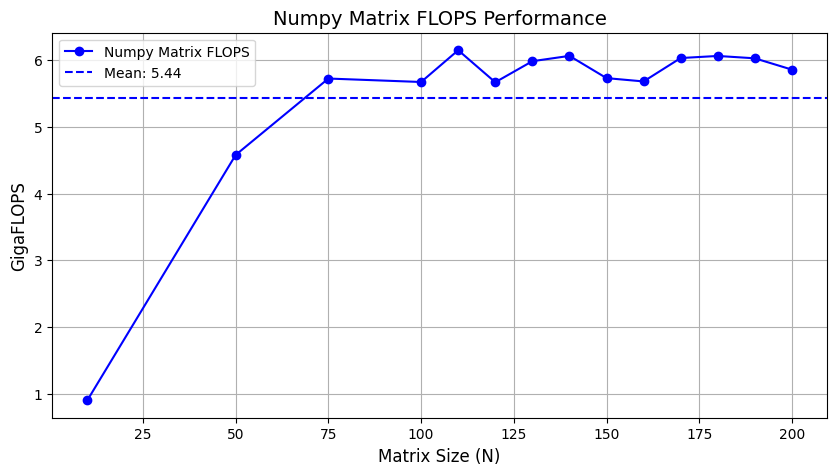

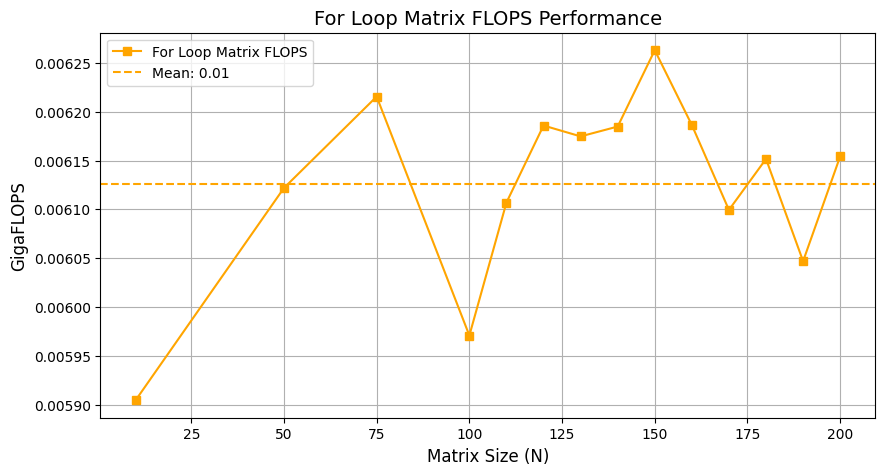

In [25]:
mean_numpy_flops = numpy_matrix_flops.mean()
mean_for_loop_flops = for_loop_matrix_flops.mean()

plt.figure(figsize=(10, 5))
plt.plot(
    sizes, numpy_matrix_flops, marker="o", color="blue", label="Numpy Matrix FLOPS"
)
plt.axhline(
    y=mean_numpy_flops,
    color="blue",
    linestyle="--",
    label=f"Mean: {mean_numpy_flops:.2f}",
)
plt.xlabel("Matrix Size (N)", fontsize=12)
plt.ylabel("GigaFLOPS", fontsize=12)
plt.title("Numpy Matrix FLOPS Performance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(
    sizes,
    for_loop_matrix_flops,
    marker="s",
    color="orange",
    label="For Loop Matrix FLOPS",
)
plt.axhline(
    y=mean_for_loop_flops,
    color="orange",
    linestyle="--",
    label=f"Mean: {mean_for_loop_flops:.2f}",
)
plt.xlabel("Matrix Size (N)", fontsize=12)
plt.ylabel("GigaFLOPS", fontsize=12)
plt.title("For Loop Matrix FLOPS Performance", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

There is some uncertainty in the GigaFLOPS calculation for smaller matrices but we can see that the values converge with larger matrices. The theoretical peak performance of my computer (M2 Mac Air) is 3.6 TFLOPs, for the numpy matrix multiplication we are getting around 4.3 GFLOPs which is around 0.12% of the peak performance.

In [26]:
theoretical_peak = 3600 # 3.6 TFLOPs
numpy_utilization = mean_numpy_flops / theoretical_peak
for_loop_utilization = mean_for_loop_flops / theoretical_peak
logger.info(f"Numpy Matrix Utilization: {(numpy_utilization*100):.6f}%")
logger.info(f"For Loop Matrix Utilization: {(for_loop_utilization*100):.6f}%")

INFO - Numpy Matrix Utilization: 0.151083%
INFO - For Loop Matrix Utilization: 0.000170%


### Task 2.4
THe above shown data is from the latest run on 6th of March instead of the previously mentioned and also using a M3 Pro Macbook instead. The results are very comparable as before. What can be seen using the NumPy Matrix way is that it is able to better utilize the computer's available computer power compared to the more naive for-loop implementation. This is due to the NumPy's more sophisticated and highly efficient BLAS implementation can better leverage the computer's CPU than the built in Python for-loops which involves more overhead and are interpreted instead of compiled. This all makes it so that using NumPy in this matter is highly more efficient in terms of utilizing computer capabilities. 

## Exercise 3 - Experiment with the Python Debugger
### Task 3.1 Reflection: 
#### What are the advantages of using a debugger? 
The debugger allows for the step by step execution of code which can be useful for understanding the flow of the code and identifying errors. It can also be used to inspect the values of variables at different points in the code which can be useful for identifying the source of errors. The additional functionality of inserting custom commands is useful to avoid cluttering the original code and the pm() functionality is very useful to understand and recover from crashes.
#### What challenges did you find in using the pdb debugger, if any?
None in particular as the debugger is quite intuitive and easy to use. The only challenge is remembering the commands or more specifically their shorthands.

## Bonus Exercise - Performance Analysis and Optimization of the Game of Life Code

Conways game of life courtesy of [Electronut](https://github.com/electronut/pp/blob/master/conway/conway.py):

In [31]:
"""
conway.py 

A simple Python/matplotlib implementation of Conway's Game of Life.

Author: Mahesh Venkitachalam
"""

import sys, argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ON = 255
OFF = 0
vals = [ON, OFF]


def randomGrid(N):
    """returns a grid of NxN random values"""
    return np.random.choice(vals, N * N, p=[0.2, 0.8]).reshape(N, N)


def addGlider(i, j, grid):
    """adds a glider with top left cell at (i, j)"""
    glider = np.array([[0, 0, 255], [255, 0, 255], [0, 255, 255]])
    grid[i : i + 3, j : j + 3] = glider


def addGosperGliderGun(i, j, grid):
    """adds a Gosper Glider Gun with top left cell at (i, j)"""
    gun = np.zeros(11 * 38).reshape(11, 38)

    gun[5][1] = gun[5][2] = 255
    gun[6][1] = gun[6][2] = 255

    gun[3][13] = gun[3][14] = 255
    gun[4][12] = gun[4][16] = 255
    gun[5][11] = gun[5][17] = 255
    gun[6][11] = gun[6][15] = gun[6][17] = gun[6][18] = 255
    gun[7][11] = gun[7][17] = 255
    gun[8][12] = gun[8][16] = 255
    gun[9][13] = gun[9][14] = 255

    gun[1][25] = 255
    gun[2][23] = gun[2][25] = 255
    gun[3][21] = gun[3][22] = 255
    gun[4][21] = gun[4][22] = 255
    gun[5][21] = gun[5][22] = 255
    gun[6][23] = gun[6][25] = 255
    gun[7][25] = 255

    gun[3][35] = gun[3][36] = 255
    gun[4][35] = gun[4][36] = 255

    grid[i : i + 11, j : j + 38] = gun


def update(frameNum, img, grid, N):
    # copy grid since we require 8 neighbors for calculation
    # and we go line by line
    newGrid = grid.copy()
    for i in range(N):
        for j in range(N):
            # compute 8-neghbor sum
            # using toroidal boundary conditions - x and y wrap around
            # so that the simulaton takes place on a toroidal surface.
            total = int(
                (
                    grid[i, (j - 1) % N]
                    + grid[i, (j + 1) % N]
                    + grid[(i - 1) % N, j]
                    + grid[(i + 1) % N, j]
                    + grid[(i - 1) % N, (j - 1) % N]
                    + grid[(i - 1) % N, (j + 1) % N]
                    + grid[(i + 1) % N, (j - 1) % N]
                    + grid[(i + 1) % N, (j + 1) % N]
                )
                / 255
            )
            # apply Conway's rules
            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON
    # update data
    img.set_data(newGrid)
    grid[:] = newGrid[:]
    return (img,)


# main() function
def main():
    # Command line args are in sys.argv[1], sys.argv[2] ..
    # sys.argv[0] is the script name itself and can be ignored
    # parse arguments
    parser = argparse.ArgumentParser(
        description="Runs Conway's Game of Life simulation."
    )
    # add arguments
    parser.add_argument("--grid-size", dest="N", required=False)
    parser.add_argument("--mov-file", dest="movfile", required=False)
    parser.add_argument("--interval", dest="interval", required=False)
    parser.add_argument("--glider", action="store_true", required=False)
    parser.add_argument("--gosper", action="store_true", required=False)
    args = parser.parse_args()

    # set grid size
    N = 100
    if args.N and int(args.N) > 8:
        N = int(args.N)

    # set animation update interval
    updateInterval = 50
    if args.interval:
        updateInterval = int(args.interval)

    # declare grid
    grid = np.array([])
    # check if "glider" demo flag is specified
    if args.glider:
        grid = np.zeros(N * N).reshape(N, N)
        addGlider(1, 1, grid)
    elif args.gosper:
        grid = np.zeros(N * N).reshape(N, N)
        addGosperGliderGun(10, 10, grid)
    else:
        # populate grid with random on/off - more off than on
        grid = randomGrid(N)

    # set up animation
    fig, ax = plt.subplots()
    img = ax.imshow(grid, interpolation="nearest")
    ani = animation.FuncAnimation(
        fig,
        update,
        fargs=(
            img,
            grid,
            N,
        ),
        frames=10,
        interval=updateInterval,
        save_count=50,
    )

    # # of frames?
    # set output file
    if args.movfile:
        ani.save(args.movfile, fps=30, extra_args=["-vcodec", "libx264"])

    plt.show()


# call main
if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--grid-size N] [--mov-file MOVFILE]
                             [--interval INTERVAL] [--glider] [--gosper]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/marcuscarlbom/Library/Jupyter/runtime/kernel-v3116f0b3839ec127280b9517ef47ef17137f7c480.json


SystemExit: 2

Results from running the code using cProfiler and having different grid sizes (as seen above but by also removing animation features)

100, 1.025s

200, 2.563s

400, 9.512s

800, 37.110s


In [ ]:
x = [100, 200, 400, 800]
y = [1.025, 2.563, 9.512, 37.110]

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Execution Time')
plt.title('Execution Time vs Input Size', fontsize=16)
plt.xlabel('Input Size', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


We decided to use cProfiler and line_profiler to check where the perfomance bottlenecks are. cProfile showed that the largest bottleneck is in the function run_one_step. Using the more fine-grained result from line_profiler showed that the majority of the bottleneck, 50%, was in the line of grid. This means that making a better matrix system would result in the best performance gain.

As asked for screenshots shows here newly run examples of what is explained above. The found bottleneck of run_one_step is the name we have in our code but the name given in the repo is "update". This is where the rest of the code and explanation is based off of. See below the screenshot for cProfiler then lineProfiler:

![Alt Text](image.png)

Below is the lineProfiler which shows about the same result as previously mentioned of 50% when handling the grid:

![Alt Text](image2.png)

If recompiled again these images disappear, beware.


Our changes consist of making it possible to run it without ui by giving the flag --no-gui and also optimizing the matrix calcuations. This can be seen in the new update function run_one_step().

In [ ]:
"""
conway.py

A simple Python/matplotlib implementation of Conway's Game of Life.

Author: Mahesh Venkitachalam
"""

import argparse
import sys

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

ON = 255
OFF = 0
vals = [ON, OFF]


def randomGrid(N):
    """returns a grid of NxN random values"""
    return np.random.choice(vals, N * N, p=[0.2, 0.8]).reshape(N, N)


def addGlider(i, j, grid):
    """adds a glider with top left cell at (i, j)"""
    glider = np.array([[0, 0, 255], [255, 0, 255], [0, 255, 255]])
    grid[i : i + 3, j : j + 3] = glider


def addGosperGliderGun(i, j, grid):
    """adds a Gosper Glider Gun with top left cell at (i, j)"""
    gun = np.zeros(11 * 38).reshape(11, 38)

    gun[5][1] = gun[5][2] = 255
    gun[6][1] = gun[6][2] = 255

    gun[3][13] = gun[3][14] = 255
    gun[4][12] = gun[4][16] = 255
    gun[5][11] = gun[5][17] = 255
    gun[6][11] = gun[6][15] = gun[6][17] = gun[6][18] = 255
    gun[7][11] = gun[7][17] = 255
    gun[8][12] = gun[8][16] = 255
    gun[9][13] = gun[9][14] = 255

    gun[1][25] = 255
    gun[2][23] = gun[2][25] = 255
    gun[3][21] = gun[3][22] = 255
    gun[4][21] = gun[4][22] = 255
    gun[5][21] = gun[5][22] = 255
    gun[6][23] = gun[6][25] = 255
    gun[7][25] = 255

    gun[3][35] = gun[3][36] = 255
    gun[4][35] = gun[4][36] = 255

    grid[i : i + 11, j : j + 38] = gun


def update(frameNum, img, grid, N):
    # copy grid since we require 8 neighbors for calculation
    # and we go line by line
    newGrid = grid.copy()
    for i in range(N):
        for j in range(N):
            # compute 8-neghbor sum
            # using toroidal boundary conditions - x and y wrap around
            # so that the simulaton takes place on a toroidal surface.
            total = int(
                (
                    grid[i, (j - 1) % N]
                    + grid[i, (j + 1) % N]
                    + grid[(i - 1) % N, j]
                    + grid[(i + 1) % N, j]
                    + grid[(i - 1) % N, (j - 1) % N]
                    + grid[(i - 1) % N, (j + 1) % N]
                    + grid[(i + 1) % N, (j - 1) % N]
                    + grid[(i + 1) % N, (j + 1) % N]
                )
                / 255
            )
            # apply Conway's rules
            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON
    # update data
    img.set_data(newGrid)
    grid[:] = newGrid[:]
    return (img,)


def run_one_step(grid, N):
    newGrid = grid.copy()
    neighbors_count = (
        np.roll(grid, 1, axis=0)
        + np.roll(grid, -1, axis=0)
        + np.roll(grid, 1, axis=1)
        + np.roll(grid, -1, axis=1)
        + np.roll(np.roll(grid, 1, axis=0), 1, axis=1)
        + np.roll(np.roll(grid, 1, axis=0), -1, axis=1)
        + np.roll(np.roll(grid, -1, axis=0), 1, axis=1)
        + np.roll(np.roll(grid, -1, axis=0), -1, axis=1)
    ) // 255
    for i in range(N):
        for j in range(N):
            if grid[i, j] == ON:
                if (neighbors_count[i, j] < 2) or (neighbors_count[i, j] > 3):
                    newGrid[i, j] = OFF
            else:
                if neighbors_count[i, j] == 3:
                    newGrid[i, j] = ON
    return newGrid


# main() function
def main():
    # Command line args are in sys.argv[1], sys.argv[2] ..
    # sys.argv[0] is the script name itself and can be ignored
    # parse arguments
    parser = argparse.ArgumentParser(
        description="Runs Conway's Game of Life simulation."
    )
    # add arguments
    parser.add_argument("--grid-size", dest="N", required=False)
    parser.add_argument("--mov-file", dest="movfile", required=False)
    parser.add_argument("--interval", dest="interval", required=False)
    parser.add_argument("--glider", action="store_true", required=False)
    parser.add_argument(
        "--no-gui",
        action="store_true",
        required=False,
    )
    parser.add_argument("--gosper", action="store_true", required=False)
    args = parser.parse_args()

    # set grid size
    N = 100
    if args.N and int(args.N) > 8:
        N = int(args.N)

    # set animation update interval
    updateInterval = 50
    if args.interval:
        updateInterval = int(args.interval)

    # declare grid
    grid = np.array([])
    # check if "glider" demo flag is specified
    if args.glider:
        grid = np.zeros(N * N).reshape(N, N)
        addGlider(1, 1, grid)
    elif args.gosper:
        grid = np.zeros(N * N).reshape(N, N)
        addGosperGliderGun(10, 10, grid)
    else:
        # populate grid with random on/off - more off than on
        grid = randomGrid(N)

    # If --no-gui is set, just run the update loop for X iterations
    if args.no_gui:
        iterations = 50  # example fixed number of iterations
        for _ in range(iterations):
            grid = run_one_step(grid, N)
        sys.exit(0)  # end here

    # set up animation
    fig, ax = plt.subplots()
    img = ax.imshow(grid, interpolation="nearest")
    ani = animation.FuncAnimation(
        fig,
        update,
        fargs=(
            img,
            grid,
            N,
        ),
        frames=10,
        interval=updateInterval,
        save_count=50,
    )

    # # of frames?
    # set output file
    if args.movfile:
        ani.save(args.movfile, fps=30, extra_args=["-vcodec", "libx264"])

    plt.show()


# call main
if __name__ == "__main__":
    main()


The most efficient way to better the performance on the grid is to not use python built-in matrix management tools. By doing the entire calculation on the grid at the start using np.roll, which are efficient and quick operations to do using NumPy, we manage to make it a lot faster than before. Adding together all 8 matrices into one is very quick for NumPu and is a quick way to have a matrix containing the number of neighbours. Using line_profiler shows now that the entire part of calculating the grid takes only 0.9% of execution time instead of 50%. The results using cProfiler shows that the optimized code had the results of:

| Grid size | Time (s) |
|-----------|----------|
| 100 | 1.122 |
| 200 | 1.250 |
| 400 | 2.688 |
| 800 | 7.349 |

There was a decrease in performance compared to previous code when running at matrices sized 100x100, running about 0.1s slower. However it had a noticeable improvement at higher matrix sizes like N = 200, 400 and 800. It showed at 800 to have an improvement of 30 seconds, about a fifth of the total execution time when using the old code.

In [ ]:
x = [100, 200, 400, 800]
y = [1.122, 1.250, 2.688, 7.349]

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Execution Time')
plt.title('Execution Time vs Input Size', fontsize=16)
plt.xlabel('Input Size', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

By profiling this code we now saw that the biggest bottleneck was the O(N^2) for-loop in the run_one_step function. By creating truth matrices combined with np.where we were able to remove the for-loop and make the code more efficient.

In [ ]:
def run_one_step(grid, N):
    new_grid = grid.copy()
    neighbors_count = (
        np.roll(grid, 1, axis=0)
        + np.roll(grid, -1, axis=0)
        + np.roll(grid, 1, axis=1)
        + np.roll(grid, -1, axis=1)
        + np.roll(grid, (1, 1), axis=(0, 1))
        + np.roll(grid, (-1, -1), axis=(0, 1))
        + np.roll(grid, (-1, 1), axis=(0, 1))
        + np.roll(grid, (1, -1), axis=(0, 1))
    ) // 1
    survivor = ((neighbors_count == 2) | (neighbors_count == 3)) & (grid == ON)
    new_born = (neighbors_count == 3) & (grid == OFF)
    new_grid = np.where(new_born | survivor, ON, OFF).astype(int)
    return new_grid

The results are now:

| Grid size | Time (s) |
|-----------|------|
| 100       | 0.474 |
| 200       | 0.490 |
| 400       | 0.443 |
| 800       | 0.712 |

which is a significant improvement in performance compared to the previous code.

In [ ]:
logger.info(
    f"It is {1.122 / 0.474 :.6f} times faster at grid size 100."
)
logger.info(
    f"It is {1.250 / 0.490 :.6f} times faster at grid size 200."
)
logger.info(
    f"It is { 2.688 / 0.443 :.6f} times faster at grid size 400."
)
logger.info(
    f"It is {7.349 / 0.712 :.6f} times faster at grid size 800."
)

In [ ]:
x = [100, 200, 400, 800]
y = [0.474, 0.490, 0.443, 0.712]

plt.figure(figsize=(8, 6))
plt.plot(x, y, marker="o", linestyle="-", color="b", label="Execution Time")
plt.title("Execution Time vs Input Size", fontsize=16)
plt.xlabel("Input Size", fontsize=14)
plt.ylabel("Execution Time (seconds)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
